In [ ]:
!pip install transformers

In [ ]:
import logging

logging.getLogger('transformers').setLevel(logging.ERROR)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

import numpy as np


In [ ]:
import warnings
warnings.filterwarnings('ignore')

##DATASET

In [ ]:
markup = pd.read_json('/content/drive/MyDrive/manipulation_markup/markup_final.json', lines=True)

In [ ]:
markup

In [ ]:
data = pd.DataFrame()

first_sent = []
second_sent = []
label = []

for j in range(len(markup)):
  text = markup.iloc[j]
  some_idx = 0
  for token in text['output_result']:
    if token['manipulation_target_id'] != 'no-entity':
      for i, name in enumerate(text['input_entitiesdata']):
        if name['from'] < token['start']:
          if len(text['input_input'][name['from']:token['start']]) > 0:
            first_sent.append(text['input_input'][name['from']:name['to']])
          else:
            first_sent.append('')
          second_sent.append(text['input_input'][token['start']-1:token['end']])
          if i == int(token['manipulation_target_id']):
            label.append(1)
          else:
            if some_idx % 3 == 0:
              label.append(0)
            else:
              first_sent.pop()
              second_sent.pop()

        if token['start'] < name['from']:
          first_sent.append(text['input_input'][token['start']-1:token['end']])
          if len(text['input_input'][name['from']:name['to']]) > 0:
            second_sent.append(text['input_input'][token['end']:name['to']])
          else:
            second_sent.append('')
          if i == int(token['manipulation_target_id']):
            label.append(1)
          else:
            if some_idx % 3 == 0:
              label.append(0)
            else:
              first_sent.pop()
              second_sent.pop() 

        some_idx+=1

data['first_sent'] = pd.Series(first_sent)
data['second_sent'] = pd.Series(second_sent)
data['label'] = pd.Series(label)

In [ ]:
data[data['label']==1].count()

first_sent     7383
second_sent    7383
label          7383
dtype: int64

In [ ]:
len(data)

47606

In [ ]:
len(label)-len(first_sent)


0

In [ ]:
from transformers import BertTokenizer, BertForNextSentencePrediction
import torch

In [ ]:
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny")

In [ ]:
pairs_of_sent = []
for j in range(len(data)):
  pairs_of_sent.append((data['first_sent'].iloc[j], data['second_sent'].iloc[j]))


In [ ]:
len(pairs_of_sent)

47606

In [ ]:
encod_text_train = tokenizer.batch_encode_plus(pairs_of_sent[:43000], return_tensors='pt', truncation=True, padding = 'max_length', max_length = 100)
encod_text_val = tokenizer.batch_encode_plus(pairs_of_sent[43000:45000], return_tensors='pt', truncation=True, padding = 'max_length', max_length = 100)

In [ ]:
labels_train = torch.tensor((data['label'].iloc[:43000].values))
labels_val = torch.tensor((data['label'].iloc[43000:45000].values))

In [ ]:
train_seq = encod_text_train['input_ids']
train_mask = encod_text_train['attention_mask']

val_seq = encod_text_val['input_ids']
val_mask = encod_text_val['attention_mask']

In [ ]:
train_seq.shape

torch.Size([43000, 100])

In [ ]:
train_data = TensorDataset(train_seq, train_mask, labels_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = 200)

val_data = TensorDataset(val_seq, val_mask, labels_val)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = 200)

##Model

In [ ]:
import torch, torch.nn as nn

In [ ]:
from transformers import AutoModel
bert = AutoModel.from_pretrained("cointegrated/rubert-tiny")

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#for param in bert.parameters():
 #param.requires_grad = False

class BERT_metric(nn.Module):
    
    def __init__(self, bert):
        super(BERT_metric, self).__init__()
        self.bert = bert
        self.drop1 = nn.Dropout(0.6)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.fc1 = nn.Linear(312,156)
        self.drop2 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(156,2)
        #self.fc3 = nn.Linear(256,2)
    
    def forward(self, sent_id, mask):
        _, bert_out = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.drop1(bert_out)
        x = self.relu1(x)
        x = self.fc1(x)
        x = self.drop2(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = BERT_metric(bert)
model = model.to(device)

<All keys matched successfully>

##Training

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),
                 lr = 1e-6)

In [ ]:
sc=torch.tensor([0.6,1.4]).to(device)

In [ ]:
loss_f = nn.CrossEntropyLoss(weight=sc)

In [ ]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = loss_f(preds, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

In [ ]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_labels = []
    correct = 0
    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            _, preds_label = torch.max(preds, 1)
            
            correct += (preds_label == labels).sum().item()
            
            loss = loss_f(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels.detach().cpu().numpy())
    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds, total_labels

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
train_losses=[]
valid_losses=[]
f_1 = []

In [ ]:
#best_valid_loss = float('inf')

In [ ]:
epochs = 40

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    valid_loss, preds, labels = evaluate()
    preds = torch.tensor(preds)
    _, val_idx = torch.max(preds, 1)
    lablz = []
    for arr in labels:
      for a in arr:
        lablz.append(a)

    #if valid_loss < best_valid_loss:
        #best_valid_loss = valid_loss
        #torch.save(model.state_dict(), f'/content/drive/MyDrive/atemp_100f1_dip.pt') 
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    f_1.append(f1_score(val_idx, lablz))
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print('acc = ', accuracy_score(val_idx, lablz))
    #print('rec = ', recall_score(val_idx, lablz))
    #print('pr = ', precision_score(val_idx, lablz))
    print('f1 = ', f1_score(val_idx, lablz))

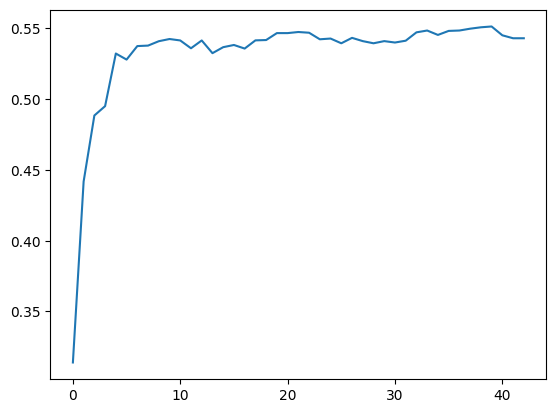

In [ ]:
plt.plot(f_1)

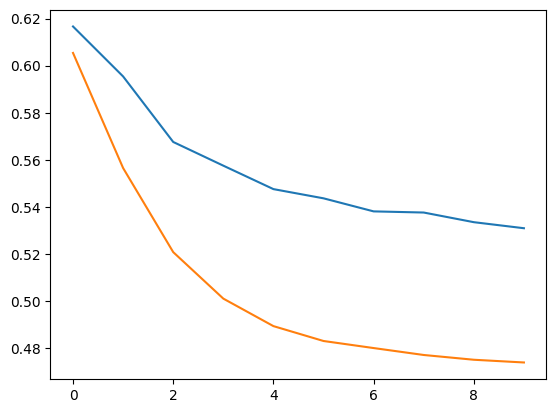

In [ ]:
plt.plot(train_losses)
plt.plot(valid_losses)

In [ ]:
encod_text_test = tokenizer.batch_encode_plus(pairs_of_sent[45000:47000], return_tensors='pt', truncation=True, padding = 'max_length', max_length = 100)

In [ ]:
labels_test = torch.tensor((data['label'].iloc[45000:47000].values-1)*(-1))

In [ ]:
test_seq = encod_text_test['input_ids']
test_mask = encod_text_test['attention_mask']

In [ ]:
test_data = TensorDataset(test_seq, test_mask, labels_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = 50)

In [ ]:
def testing():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_labels = []
    correct = 0
    for step, batch in tqdm(enumerate(demo_dataloader), total = len(demo_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            _, preds_label = torch.max(preds, 1)
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels.detach().cpu().numpy())
    total_preds = np.concatenate(total_preds, axis = 0)

    return total_preds, total_labels

In [ ]:
pred_test, labl = testing()

100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


In [ ]:
pred_test = torch.tensor(pred_test)
_, test_idx = torch.max(pred_test, 1)

In [ ]:
lablz = []
for arr in labl:
  for a in arr:
    lablz.append(a)

In [ ]:
acc = accuracy_score(test_idx, lablz)
rec = recall_score(test_idx, lablz)
pr = precision_score(test_idx, lablz)

In [ ]:
print(acc)
print(rec)
print(pr)

0.6666666666666666
0.5
1.0


##DEMO

In [ ]:
data_demo = pd.DataFrame()

first_sent = []
second_sent = []
label = []
num_of_pair = []
entity_start = []
entity_end = []
token_start = []
token_end = []

for j in range(1):
  text = markup.iloc[89]
  some_idx = 0
  num = 0
  for token in text['output_result']:
    if token['manipulation_target_id'] != 'no-entity':
      for i, name in enumerate(text['input_entitiesdata']):
        num_of_pair.append(num)
        entity_start.append(name['from'])
        entity_end.append(name['to'])
        token_start.append(token['start'])
        token_end.append(token['end'])

        if name['from'] < token['start']:
          if len(text['input_input'][name['from']:token['start']]) > 0:
            first_sent.append(text['input_input'][name['from']-1:name['to']])
          else:
            first_sent.append('')
          second_sent.append(text['input_input'][token['start']-1:token['end']])
          if i == int(token['manipulation_target_id']):
            label.append(1)
          else:
            if some_idx % 1 == 0:
              label.append(0)
            else:
              first_sent.pop()
              second_sent.pop()

        if token['start'] < name['from']:
          first_sent.append(text['input_input'][token['start']-1:token['end']])
          if len(text['input_input'][name['from']:name['to']]) > 0:
            second_sent.append(text['input_input'][token['end']-1:name['to']])
          else:
            second_sent.append('')
          if i == int(token['manipulation_target_id']):
            label.append(1)
          else:
            if some_idx % 1 == 0:
              label.append(0)
            else:
              first_sent.pop()
              second_sent.pop() 

        some_idx+=1

data_demo['first_sent'] = pd.Series(first_sent)
data_demo['second_sent'] = pd.Series(second_sent)
data_demo['label'] = pd.Series(label)
data_demo['num'] = pd.Series(num_of_pair)
data_demo['entity_start'] = pd.Series(entity_start)
data_demo['entity_end'] = pd.Series(entity_end)
data_demo['token_start'] = pd.Series(token_start)
data_demo['token_end'] = pd.Series(token_end)


In [ ]:
pairs_of_sent_demo = []
for j in range(len(data_demo)):
  pairs_of_sent_demo.append((data_demo['first_sent'].iloc[j], data_demo['second_sent'].iloc[j]))

In [ ]:
len(data_demo)

6

In [ ]:
encod_text_demo = tokenizer.batch_encode_plus(pairs_of_sent_demo, return_tensors='pt', truncation=True, padding = 'max_length', max_length = 100)
labels_demo = torch.tensor((data_demo['label'].values))
demo_seq = encod_text_demo['input_ids']
demo_mask = encod_text_demo['attention_mask']

In [ ]:
demo_data = TensorDataset(demo_seq, demo_mask, labels_demo)
demo_dataloader = DataLoader(demo_data,batch_size =len(demo_seq))

In [ ]:
data_demo

,first_sent,second_sent,label,num,entity_start,entity_end,token_start,token_end,prediction
0,,СМИ: в жилом доме в центре Москвы найдена мина...,0,0,0,3,1,63,1
1,СМИ: в жилом доме в центре Москвы найдена мина...,,1,0,27,33,1,63,1
2,СМИ: в жилом доме в центре Москвы найдена мина...,Малом Власьевском переулке,0,0,63,89,1,63,1
3,,в Малом Власьевском переулке нашли мину. Как с...,0,0,0,3,62,306,0
4,Москвы,в Малом Власьевском переулке нашли мину. Как с...,0,0,27,33,62,306,0
5,в Малом Власьевском переулке нашли мину. Как с...,,1,0,63,89,62,306,1


In [ ]:
data_demo['prediction'] = pd.Series(test_idx)